In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import arcfish as af
from utils import out_dire
from utils.data import DataTree
dtree = DataTree("../data")

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
adata_sox2 = af.pp.FOF_CT_Loader(
    dtree["huang_ng_2021", "between"]).create_adata("chr3")
for c in "XYZ":
    adata_sox2.layers[c][:,25] = np.nan
allele = adata_sox2.obs.index.str.replace(r"^.*_", "", regex=True)
adata_sox2.obs["allele"] = allele

cast = adata_sox2[adata_sox2.obs["allele"]=="CAST"].copy()
c129 = adata_sox2[adata_sox2.obs["allele"]=="129"].copy()

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/utils/load.py:207: UserWarning: FOF_CT-core data has less columns than what specified in the header. Additional columns will be ignored.
  warnings.warn(


In [4]:
af.pp.filter_normalize(cast)
raw_var = np.stack([cast.varp[f"raw_var_{c}"] for c in "XYZ"])

/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


In [5]:
d1d = cast.var.Chrom_Start.values
warnings.filterwarnings("ignore", "divide by zero")
log_d1map = np.log(np.abs(d1d[None,:] - d1d[:,None]))
warnings.filterwarnings("default")

uidx = np.triu_indices(log_d1map.shape[0], k=1)
raw_strata_var = af.pp.eval._lowess_multivariate(
    log_d1map, np.log(raw_var[:,*uidx])
)


In [6]:
def brownian_motion(n_steps, dt=1.0, coef=1.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    trajectory = np.zeros((3, n_steps+1))
    sigma = np.sqrt(2 * coef * dt)
    displacements = np.random.normal(0, sigma, size=(3, n_steps))
    for t in range(n_steps):
        trajectory[:, t+1] = trajectory[:, t] + displacements[:, t]
    return trajectory

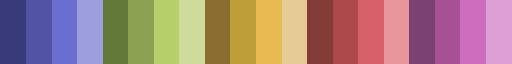

In [7]:
plt.colormaps.get_cmap("tab20b")

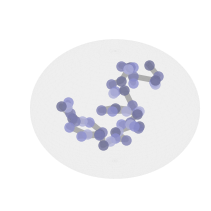

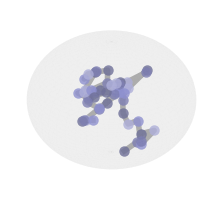

In [8]:
for seed in [14, 15]:
    trace = brownian_motion(50, seed=seed)
    fig = plt.figure(figsize=(2, 2))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(*trace, "-", color="gray", linewidth=4, alpha=.8)
    ax.axis('off')
    for i, row in enumerate(trace.T):
        color = plt.colormaps.get_cmap("tab20b")(i%4)
        ax.plot(*row, ".", color=color, markersize=15, alpha=0.8)
        
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    a, b, c = np.ptp(trace, axis=1)
    bkgd_ell = np.stack([
        a * np.outer(np.cos(u), np.sin(v)),
        b * np.outer(np.sin(u), np.sin(v)),
        c * np.outer(np.ones(np.size(u)), np.cos(v))
    ]) + trace.mean(axis=1)[:,None,None]
    ax.plot_surface(*bkgd_ell, color='lightgray', shade=False, alpha=0.2)

    ax.set(**{f"{c}lim": (t.min() - r*.2, t.max() + r*.2) 
            for c, t, r in zip("xyz", trace, [a, b, c])})
    fig.savefig(os.path.join(out_dire, f"cartoon_trace_{seed}.pdf"), bbox_inches="tight")

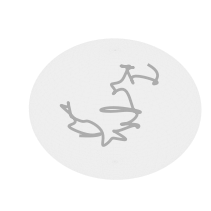

In [9]:
from scipy.interpolate import interp1d
p = 50
trace = brownian_motion(p, seed=14)
trace_cts = np.stack([
    interp1d(np.linspace(0, 1, p+1), t, kind='cubic')(np.linspace(0, 1, 300))
    for t in trace
])

fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*trace_cts, "-", color="gray", linewidth=2, alpha=.8)
ax.axis('off')
    
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
a, b, c = np.ptp(trace_cts, axis=1)
bkgd_ell = np.stack([
    a * np.outer(np.cos(u), np.sin(v)),
    b * np.outer(np.sin(u), np.sin(v)),
    c * np.outer(np.ones(np.size(u)), np.cos(v))
]) + trace_cts.mean(axis=1)[:,None,None]
ax.plot_surface(*bkgd_ell, color='lightgray', shade=False, alpha=0.2)

ax.set(**{f"{c}lim": (t.min() - r*.2, t.max() + r*.2) 
        for c, t, r in zip("xyz", trace, [a, b, c])})
fig.savefig(os.path.join(out_dire, "trace_raw.pdf"), bbox_inches="tight")

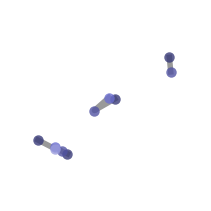

In [10]:
fig, tax = plt.subplots(figsize=(2, 2))
for segment in [slice(1, 3), slice(20, 23), slice(40, 45)]:
    tax.plot(*trace[:2,segment], "-", color="gray", linewidth=4, alpha=.8)
    for i, row in enumerate(trace[:2,segment].T):
        color = plt.colormaps.get_cmap("tab20b")(i%4)
        tax.plot(*row, ".", color=color, markersize=15, alpha=0.8)
tax.set(xlim=ax.get_xlim(), ylim=ax.get_ylim())
tax.axis('off')
tax.grid(False)
fig.savefig(os.path.join(out_dire, "trace_2d_1.pdf"), transparent=True, bbox_inches="tight")

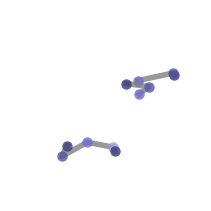

In [11]:
fig, tax = plt.subplots(figsize=(2, 2))
for segment in [slice(3, 6), slice(23, 26), slice(45, 50)]:
    tax.plot(*trace[:2,segment], "-", color="gray", linewidth=4, alpha=.8)
    for i, row in enumerate(trace[:2,segment].T):
        color = plt.colormaps.get_cmap("tab20b")(i%4)
        tax.plot(*row, ".", color=color, markersize=15, alpha=0.8)
tax.set(xlim=ax.get_xlim(), ylim=ax.get_ylim())
tax.axis('off')
tax.grid(False)
fig.savefig(os.path.join(out_dire, "trace_2d_2.pdf"), transparent=True, bbox_inches="tight")

In [13]:
d1d = cast.var.Chrom_Start.values
warnings.filterwarnings("ignore", "divide by zero")
log_d1map = np.log(np.abs(d1d[None,:] - d1d[:,None]))
warnings.filterwarnings("default")

uidx = np.triu_indices(log_d1map.shape[0], k=1)
raw_strata_var = af.pp.eval._lowess_multivariate(
    log_d1map, np.log(raw_var[:,*uidx])
)

a = 0
plt_df = pd.DataFrame({
    "1d": np.exp(log_d1map[uidx]),
    "var": raw_var[a][uidx],
    "strata_var": raw_strata_var[a][uidx]
})

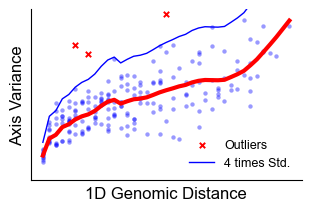

In [14]:
sub_plt_df = plt_df.dropna().sample(200, random_state=8).copy()
fig, ax = plt.subplots(figsize=(3, 2))
sns.scatterplot(sub_plt_df, x="1d", y="var", color="blue", alpha=.4, ax=ax, s=10, linewidth=0)
sns.lineplot(sub_plt_df, x="1d", y="strata_var", ax=ax, color="red", linewidth=3)
ax.scatter([3e4, 4e4, 10e4], [3e4, 2.8e4, 3.7e4], color="r", 
           marker="x", s=15, label="Outliers")
df = sub_plt_df.drop_duplicates("1d").sort_values("1d")
ax.plot(df["1d"], 1.53 * df["strata_var"], 
        color="blue", linewidth=1, label=r"4 times Std.")
ax.set(xticks=[], yticks=[], ylim=(0, 38e3))
ax.set_xlabel("1D Genomic Distance", fontsize=12)
ax.set_ylabel("Axis Variance", fontsize=12)
ax.grid(False)
ax.legend(loc="lower right", fontsize=9)

fig.savefig(os.path.join(out_dire, "lowess.pdf"), bbox_inches="tight")

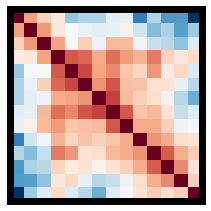

In [15]:
cast_sub = cast[:,::3]
fig, ax = plt.subplots(figsize=(2, 2))
af.pl.pairwise_heatmap(cast_sub.varp["raw_var_X"], ax=ax, cbar=False)
for spine in ax.spines.values():
    spine.set(visible=True, lw=5, edgecolor="black")
fig.savefig(os.path.join(out_dire, "pairwise_heatmap_raw.pdf"), bbox_inches="tight", pad_inches=0)

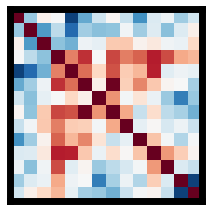

In [16]:
fig, ax = plt.subplots(figsize=(2, 2))
af.pl.pairwise_heatmap(cast_sub.varp["var_X"], ax=ax, vmin=.65, vmax=1.35, cbar=False)
for spine in ax.spines.values():
    spine.set(visible=True, lw=5, edgecolor="black")
fig.savefig(os.path.join(out_dire, "pairwise_heatmap_norm.pdf"), bbox_inches="tight", pad_inches=0)

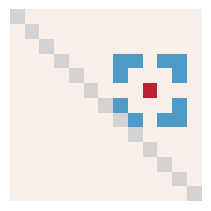

In [17]:
from matplotlib.colors import ListedColormap
loop_bkgd = af.tl.AxisWiseF.ij_background(
    5, 9, np.arange(13)*25e3, 50e3
).astype("int64")
np.fill_diagonal(loop_bkgd, 2)
loop_bkgd[5, 9] = 3
fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(loop_bkgd, cmap=ListedColormap(
    [plt.colormaps["RdBu"](120), plt.colormaps["RdBu"](200), 
     "lightgray", plt.colormaps["RdBu"](30)]
), alpha=1, square=True, cbar=False, ax=ax)
ax.set(xticks=[], yticks=[])
ax.grid(False)

fig.savefig(os.path.join(out_dire, "alg_loop.pdf"), bbox_inches="tight", pad_inches=0)

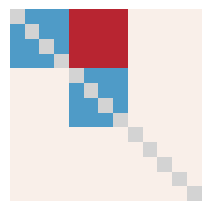

In [18]:
domain = np.zeros((13, 13), dtype="int64")
domain[:4, :4] = domain[4:8, 4:8] = 1
domain[:4, 4:8] = 3
np.fill_diagonal(domain, 2)
fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(domain, cmap=ListedColormap(
    [plt.colormaps["RdBu"](120), plt.colormaps["RdBu"](200), 
     "lightgray", plt.colormaps["RdBu"](30)]
), alpha=1, square=True, cbar=False, ax=ax)
ax.set(xticks=[], yticks=[])
ax.grid(False)

fig.savefig(os.path.join(out_dire, "alg_domain.pdf"), bbox_inches="tight", pad_inches=0)

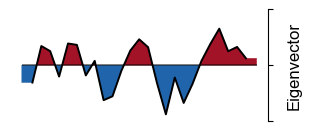

In [19]:
l, V = np.linalg.eig(cast.varp["var_X"][:25,:25])
fig, ax = plt.subplots(figsize=(3, 1.2))
sns.lineplot(x=np.arange(len(l)), y=V[:,8], color="k", ax=ax)
ax.spines["bottom"].set_visible(False)
xmin, xmax = ax.get_xlim()
ax.hlines([0], xmin=xmin, xmax=xmax, color="k", alpha=0.5)
x = np.linspace(xmin, xmax, 1000)
ax.fill_between(
    x, np.interp(x, np.arange(len(l)), V[:,8]), 0, 
    where=np.interp(x, np.arange(len(l)), V[:,8])>=0,
    alpha=1, color=plt.colormaps.get_cmap("RdBu")(20)
)
ax.fill_between(
    x, np.interp(x, np.arange(len(l)), V[:,8]), 0, 
    where=np.interp(x, np.arange(len(l)), V[:,8])<=0,
    alpha=1, color=plt.colormaps.get_cmap("RdBu")(230)
)
ax.set(xticks=[], yticks=[-.5, 0, .5], yticklabels=[])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.set_ylabel("Eigenvector", fontsize=12)
ax.grid(False)
fig.savefig(os.path.join(out_dire, "alg_eigvec.pdf"), bbox_inches="tight", transparent=True)

In [20]:
mat = np.zeros((30, 30), dtype="int64")
boundaries = [0, 3, 10, 14, 20, 23, 26, 30]
np.random.seed(10)
for i in range(len(boundaries)-1):
    b1, b2 = boundaries[i], boundaries[i+1]
    mat[b1:b2, b1:b2] = 2
    if np.random.random() < 0.5:
        mat[b1,b2 - 1] = mat[b2 - 1,b1] = 3
np.fill_diagonal(mat, 1)

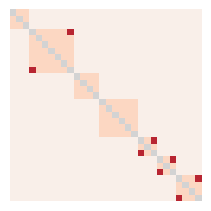

In [21]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(mat, cmap=ListedColormap(
    [plt.colormaps["RdBu"](120), "lightgray", 
     plt.colormaps["RdBu"](100), plt.colormaps["RdBu"](30)]
), alpha=1, square=True, cbar=False, ax=ax)
ax.set(xticks=[], yticks=[])
ax.grid(False)
fig.savefig(os.path.join(out_dire, "alg_loop2.pdf"), bbox_inches="tight", pad_inches=0)

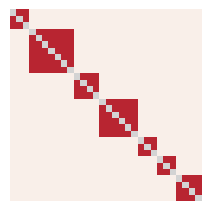

In [22]:
mat[mat > 2] = 2
fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(mat, cmap=ListedColormap(
    [plt.colormaps["RdBu"](120), plt.colormaps["RdBu"](200), 
     "lightgray", plt.colormaps["RdBu"](30)]
), alpha=1, square=True, cbar=False, ax=ax)
ax.set(xticks=[], yticks=[])
ax.grid(False)
fig.savefig(os.path.join(out_dire, "alg_domain2.pdf"), bbox_inches="tight", pad_inches=0)

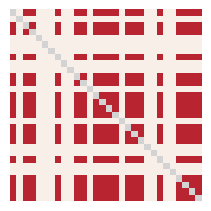

In [23]:
cpmt = np.zeros(30, dtype="int64")
np.random.seed(10)
cpmt[np.random.random(30) > 0.5] = 1
cpmt = cpmt[:,None] * cpmt[None,:]
cpmt += 1
np.fill_diagonal(cpmt, 0)
fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(cpmt, cmap=ListedColormap(
    ["lightgray", plt.colormaps["RdBu"](120), plt.colormaps["RdBu"](30)]
), alpha=1, square=True, cbar=False, ax=ax)
ax.set(xticks=[], yticks=[])
ax.grid(False)
fig.savefig(os.path.join(out_dire, "alg_cpmt2.pdf"), bbox_inches="tight", pad_inches=0)

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

i = 2

def remove_boundary(adata, i, caller, fig):
    ax, cbar = af.pl.triangle_heatmap(
        adata.varp["med_dist"], adata.var,
        fig=fig, xticklabels=["", ""], s=30, marker="D"
    )[1:]
    cbar.remove()

    ax.set_xlabel("")
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("bottom", size="30%", pad="0%")

    df1d = adata.var.copy()
    d1d = ((df1d["Chrom_End"] + df1d["Chrom_Start"])/2).values
    x, y = np.meshgrid(d1d, d1d)
    med_df = af.pl.rotate_df(pd.DataFrame({
        "x": x[np.tril_indices_from(x, 0)], 
        "y": y[np.tril_indices_from(y, 0)],
    }), -45).drop_duplicates("x")
    med_df["stat"] = np.log(adata.var["stat"].values)
    med_df.index = adata.var_names

    c = sns.palettes.color_palette("dark")
    sns.lineplot(med_df, x="x_rot", y="stat", color=c[0], ax=cax)
    sns.scatterplot(
        med_df, x="x_rot", y="stat", color=c[0], 
        linewidth=0, s=3*fig.get_size_inches()[0], ax=cax
    )
    peaks = adata.var.peak.copy()
    peaks[adata.var.stat[peaks].index[adata.var.stat[peaks].argsort() < i]] = False
    for x in med_df[peaks]["x_rot"].values:
        cax.axvline(x, ymin=0, ymax=1,
                    linestyle="-", color="k", clip_on=False)
    cax.grid(False)
    cax.spines[["top", "right"]].set_visible(True)
    cax.set(xticks=[], yticks=[], xlabel="1D Genomic Position", ylabel="Stat")
    cax.set_xlim(*ax.get_xlim())

    res = adata.var.copy()
    res["peak"] = peaks
    for _, row in caller.to_bedpe(res).iterrows():
        # Move .5 bin up
        s = (row.s1 + row.e1)/2 - (row.e1 - row.s1)/2
        e = (row.s2 + row.e2)/2 + (row.e2 - row.s2)/2
        df = af.pl.rotate_df(pd.DataFrame({"x": [e,s,s], "y": [e,e,s]}))
        ax.plot(df.x_rot, df.y_rot, color="k")
    ax.set_xlim(*cax.get_xlim())
    return ax

In [25]:
adata = af.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"],
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
}).create_adata("chr2")[:,::2].copy()
caller = af.tl.TADCaller()
adata.var = pd.merge(
    adata.var.reset_index(names="loc"), caller.call_tads(adata)
).set_index("loc")
adata.varp["med_dist"] = np.clip(af.pp.median_pdist(adata, False), .1, .55)

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/utils/eval.py:186: RuntimeWarning: Mean of empty slice
  x0 = x - np.nanmean(x, axis=1)[:,None]


/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/utils/eval.py:186: RuntimeWarning: Mean of empty slice
  x0 = x - np.nanmean(x, axis=1)[:,None]
/var/folders/r1/8ss2m8yd3616s_v12l580jcw0000gn/T/ipykernel_60302/3587433761.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


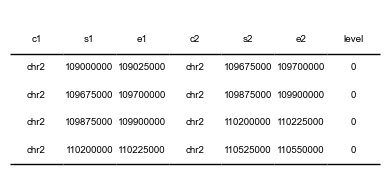

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/utils/eval.py:186: RuntimeWarning: Mean of empty slice
  x0 = x - np.nanmean(x, axis=1)[:,None]
/var/folders/r1/8ss2m8yd3616s_v12l580jcw0000gn/T/ipykernel_60302/3587433761.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


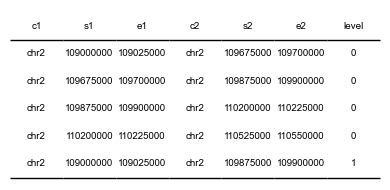

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/utils/eval.py:186: RuntimeWarning: Mean of empty slice
  x0 = x - np.nanmean(x, axis=1)[:,None]
/var/folders/r1/8ss2m8yd3616s_v12l580jcw0000gn/T/ipykernel_60302/3587433761.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


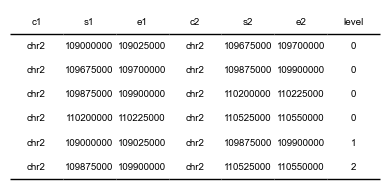

In [26]:
for k in range(3):
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.axis('off')

    df = caller.to_bedpe(
        caller.call_tads(adata)).drop(
            ["stat1", "stat2", "idx1", "idx2"], axis=1
        )
    df = df[df.level <= k]
    # Create table with minimal styling
    table = ax.table(cellText=df.values,
                    colLabels=df.columns, 
                    cellLoc='center',
                    loc='center',
                    edges='B')  # Only horizontal lines

    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1, 1.5)

    for (i, j), cell in table.get_celld().items():
        cell.set_linewidth(0)
        cell.set_edgecolor('white')
        
    # Add only top and bottom lines
    n_cols = len(df.columns)
    # Top line (header row)
    for j in range(n_cols):
        table[(0, j)].set_linewidth(1)
        table[(0, j)].set_edgecolor('black')

    # Bottom line (last row)
    n_rows = len(df)
    for j in range(n_cols):
        table[(n_rows, j)].set_linewidth(1) 
        table[(n_rows, j)].set_edgecolor('black')

    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(out_dire, f"tad_table_{k}.pdf"), bbox_inches="tight")

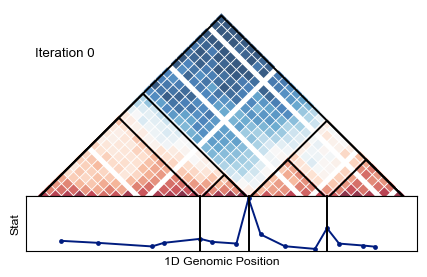

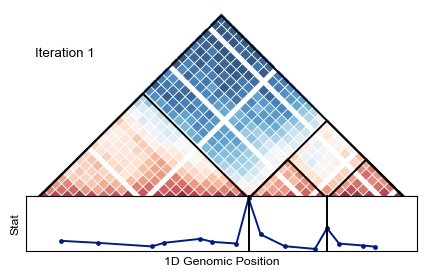

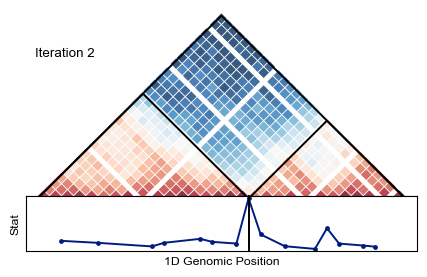

In [27]:
for i in range(3):
    fig = plt.figure(figsize=(4, 2.5))
    ax = remove_boundary(adata, i, caller, fig=fig)
    ax.set_title(f"Iteration {i}", y=0.7, x=0.1)
    fig.savefig(os.path.join(out_dire, f"remove_boundary_{i}.pdf"), bbox_inches="tight")